In [1]:
import pickle
import pandas as pd
import time
import numpy as np
import matplotlib as plt
import seaborn as sns

plt.style.use('seaborn')
%load_ext autotime

In [2]:
with open('final.pkl', 'rb') as f:
    df = pickle.load(f)

time: 77.5 ms


In [3]:
df.head()

,username,eye_color,hair,skin_tone,skin_type,skin_concerns,foundation_color,review,recommend,unhelpful,helpful,star
0,creecreex,Brown,Brunette,Deep,Normal,Cellulite,370,I have 370 and I got matched at Sephora. I lik...,1,0,14,100
1,Jijine,Brown,Black,Dark,Combination,Unknown,470,It is like my skin but better. very lightweigh...,1,0,5,100
2,bloodyblondie,Blue,Black,Porcelain,Dry,Blackheads,100,I was so nervous about trying this product bec...,1,0,5,100
3,miralanani,Brown,Brunette,Medium,Combination,Acne,270,This product was amazing! Just fell in love! T...,1,0,5,100
4,shaaliyah,Brown,Black,Deep,Combination,Acne,370,Since purchasing this foundation it's been my ...,1,0,38,100


time: 388 ms


# Case 1: Y=Star Rating

## Vectorize and Set Up Data

In [4]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

time: 129 ms


In [5]:
count_vectorizer = CountVectorizer(ngram_range=(1, 2),  
                                   stop_words='english', max_df=0.6, token_pattern="\\b[a-z][a-z]+\\b")

time: 2.52 ms


In [6]:
cv_data=count_vectorizer.fit_transform(df['review'])

time: 1.32 s


In [7]:
X=cv_data
y=df['star']

time: 1.51 ms


In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

time: 36.3 ms


## Imbalances

### Visualize

In [9]:
import matplotlib.pyplot as plt 

time: 1.82 ms


In [10]:
%matplotlib inline 

time: 14 ms


In [11]:
number_data=df.star.value_counts()

time: 7.73 ms


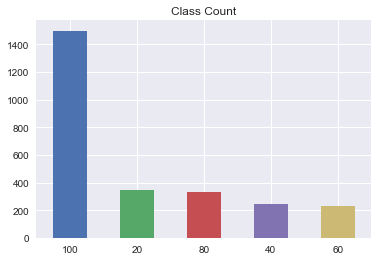

time: 473 ms


In [12]:
number_data.plot(kind='bar', title='Class Count', rot=0);

### Oversample

In [13]:
from imblearn.over_sampling import RandomOverSampler
from collections import Counter

time: 93.1 ms


In [14]:
ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_sample(X_train,y_train)

time: 24.7 ms


In [15]:
Counter(y_resampled)

Counter({'100': 875, '80': 875, '60': 875, '40': 875, '20': 875})

time: 6.18 ms


## Model

In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import naive_bayes
from sklearn.metrics import accuracy_score, mean_squared_error

time: 68 ms


In [17]:
models = [RandomForestClassifier(n_estimators=100, n_jobs=-1, max_depth=10), DecisionTreeClassifier(max_depth=None),
          LogisticRegression(C=0.1), naive_bayes.GaussianNB(),
         naive_bayes.BernoulliNB(), naive_bayes.MultinomialNB()]
model_names = ["Random Forest", "Decision Tree",'Logistic', 'Naive-Bayes Gaussian',
              'Naive-Bayes Bernoulli', 'Naive-Bayes Multinomial']

time: 2.1 ms


In [42]:
acc_comparisons=[]
for clf, name in zip(models, model_names):
    print(name)
    clf.fit(X_resampled.toarray(), y_resampled)
    preds = clf.predict_proba(X_test.toarray())
    predictions = clf.predict(X_test.toarray())
    acc=accuracy_score(y_test,predictions)
    acc_comparisons.append((acc,name))
    print(acc)

Random Forest
0.6472248353715898
Decision Tree
0.5691439322671684
Logistic
0.715898400752587
Naive-Bayes Gaussian
0.638758231420508
Naive-Bayes Bernoulli
0.7318908748824082
Naive-Bayes Multinomial
0.6923800564440263
time: 1min 9s


[(0.5691439322671684, 'Decision Tree'), (0.638758231420508, 'Naive-Bayes Gaussian'), (0.6472248353715898, 'Random Forest'), (0.6923800564440263, 'Naive-Bayes Multinomial'), (0.715898400752587, 'Logistic'), (0.7318908748824082, 'Naive-Bayes Bernoulli')]


Text(0.5,1,'Accuracy Scores')

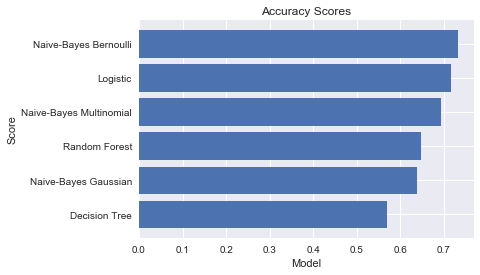

time: 209 ms


In [57]:
acc_comparisons.sort()
print(acc_comparisons)
acc_score=[score[0] for score in acc_comparisons]
acc_model_names=[score[1] for score in acc_comparisons]
plt.barh(acc_model_names,acc_score)
plt.xlabel('Model')
plt.ylabel('Score')
plt.title('Accuracy Scores')

# Case 2: Y=Helpfulness

## Set Up Data

In [19]:
y2=df['helpful']

time: 3.41 ms


In [20]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y2, test_size=0.4, random_state=42)

time: 10.8 ms


## Model

In [21]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge, LassoCV
from sklearn.cross_validation import KFold
from sklearn.metrics import mean_squared_error

time: 28.3 ms


/Users/mayamadhavan/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [22]:
regress_models = [LinearRegression(), Ridge(), Lasso(alpha=0.5), LassoCV()]
regress_model_names = ["LinearRegression", "Ridge",'Lasso', 'LassoCV']

time: 1.63 ms


In [24]:
mse_comparisons=[]
for clf, name in zip(regress_models, regress_model_names):
    print(name)
    clf.fit(X_resampled.toarray(), y_resampled)
    predictions = clf.predict(X_test.toarray())
    mse=mean_squared_error(y_test,predictions)
    mse_comparisons.append(mse)
    print(mse)

LinearRegression
502.7117016767997
Ridge
475.73000123657454
Lasso
783.5856646008219
LassoCV
544.5353616759511
time: 20min 37s


[475.73000123657454, 502.7117016767997, 544.5353616759511, 783.5856646008219]


Text(0.5,1,'MSE Scores')

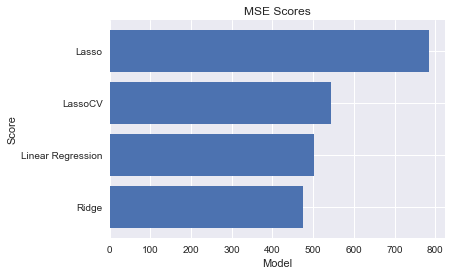

time: 192 ms


In [58]:
mse_comparisons.sort()
print(mse_comparisons)
plt.barh(["Ridge", "Linear Regression","LassoCV", "Lasso"], mse_comparisons)
plt.xlabel('Model')
plt.ylabel('Score')
plt.title('MSE Scores')

In [26]:
ridge = Ridge()
ridge.fit(X_train2, y_train2)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

time: 680 ms


In [27]:
y_predict = ridge.predict(X_train2)
ridge.score(X_train2, y_train2)

0.9961081063530135

time: 7.57 ms


In [28]:
y_predict_test = ridge.predict(X_test2)
ridge.score(X_test2, y_test2)

-0.00782057890545973

time: 7.84 ms


## Predict Helpfulness

In [29]:
def prediction(review):
    '''
    1. count vectorize inputed review
    2. run through model
    '''
    vectorized_input=count_vectorizer.transform([review])
    helpfulness=ridge.predict(vectorized_input)
    return helpfulness

time: 5.54 ms


In [30]:
prediction('''First of all, what I absolutely adore about this foundation line is that I could actually find a perfect shade match. I actually use this foundation as a benchmark to gauge the colour match of other foundations that I want to try. Its medium coverage looks nice on my skin. I personally dont really like heavy foundations because they tend to make me look like I'm wearing a mask, so I do appreciate its natural looking finish. The pump packaging is brilliant. It makes application very easy and hygienic. I havent noticed any breakouts from using this product. However, I don't think it suits my oily, textured skin. Find that it doesn't give me that "pro-filter" it advertises. I've found that it doesn't look good when I apply it to my forehead because of my texture. It also does break down throughout the day and transfers a bit when I blot. The pigment separates around my nose and smile line area over time. Also, layering the product to become more full coverage tends to make my skin look cakey, so I just stick to applying a thin layer. Nonetheless, I have enjoyed my time with Fenty, but I think I'll be looking for other foundations after I'm done with this bottle.''')

array([60.35353072])

time: 23.6 ms


In [31]:
prediction('Hated it.')

array([7.98699825])

time: 3.54 ms


In [32]:
prediction("This foundation didn't work for me at all. Poor coverage and very cakey. Didn't last even 4 hours. The finish is horrible. Will not recommend this product.")

array([-15.14454165])

time: 5.34 ms


In [33]:
prediction("i didn't buy this product but id like to say my reason as to why.. its not animal cruelty free, and it doesn't have the symbol. It doesn't say it doesn't test on animals which disappoints me...such evil")

array([-5.42373267])

time: 4.77 ms
